In [1]:
# Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
# Set NN hyperparameters
INIT_LR = 1e-3
EPOCHS = 25
BATCH_SIZE = 8

# Set directory path
image_dir = 'data'

In [3]:
# Grab images from directory and initialize list of data
print("[INFO] Loading images...")
image_paths = list(paths.list_images(image_dir))
data = []
labels = []

# Loop over images
for image_path in image_paths:
    
    # Extract class labels
    label = image_path.split(os.path.sep)[-2]
    
    # Load image and swap colors and resize for NN network
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # Update data and label list
    data.append(image)
    labels.append(label)
    
# Convert data and labels to numpy array
# Scale pixel intensity range 0-1
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] Loading images...


In [4]:
# One Hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
# Partition training data (80-20 ratio)
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, 
                                                      test_size=0.20, stratify=labels, random_state=43)

In [6]:
# Initialize data augmentation object
training_aug = ImageDataGenerator(rotation_range=15,
                                 fill_mode="nearest")

In [7]:
# Load VGG16 model, leaving FC layers off
base_model = VGG16(weights="imagenet", include_top=False, 
                   input_tensor=Input(shape=(224,224,3)))

# Construct model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# Add model on top of base model
model = Model(inputs=base_model.input, outputs=head_model)

# Loop over base model layers and freeze them
# This ensures layers will not be updated
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Compile model
print("[INFO] Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train head of network
print("[INFO] training head...")
HEAD = model.fit_generator(training_aug.flow(train_x,train_y, batch_size=BATCH_SIZE),
                          steps_per_epoch=len(train_x) // BATCH_SIZE,
                          validation_data=(test_x,test_y),
                          validation_steps=len(test_x) // BATCH_SIZE,
                          epochs=EPOCHS)

[INFO] Compiling model...
[INFO] training head...
Epoch 1/25
5/5 [==============================] - 68s 14s/step - loss: 0.8229 - accuracy: 0.6250 - val_loss: 0.6334 - val_accuracy: 0.6000
Epoch 2/25
5/5 [==============================] - 61s 12s/step - loss: 0.7979 - accuracy: 0.4750 - val_loss: 0.6841 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 68s 14s/step - loss: 0.9767 - accuracy: 0.3750 - val_loss: 0.6209 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 64s 13s/step - loss: 0.6577 - accuracy: 0.6250 - val_loss: 0.5586 - val_accuracy: 0.9000
Epoch 5/25
5/5 [==============================] - 66s 13s/step - loss: 0.7240 - accuracy: 0.5500 - val_loss: 0.5383 - val_accuracy: 0.7000
Epoch 6/25
5/5 [==============================] - 62s 12s/step - loss: 0.7122 - accuracy: 0.5250 - val_loss: 0.5159 - val_accuracy: 0.8000
Epoch 7/25
5/5 [==============================] - 61s 12s/step - loss: 0.5975 - accuracy: 0.7250 - val_loss: 0.5168 

In [9]:
# Make predictions
print("[INFO] Evaluating network...")
pred_idxs = model.predict(test_x, batch_size=BATCH_SIZE)

# Grab prediction indices
pred_idxs = np.argmax(pred_idxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), pred_idxs,target_names=lb.classes_))

[INFO] Evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
      normal       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [10]:
# Create confusionconfusion_matrix_matrix_matrix_matrix_matrix_matrix_matrixnd derive accuracy, sensitivity, and specificity
confused_matrix = confusion_matrix(test_y.argmax(axis=1), pred_idxs)
total = sum(sum(confused_matrix))
accuracy = (confused_matrix[0, 0] + confused_matrix[1, 1]) / total
sensitivity = confused_matrix[0, 0] / (confused_matrix[0, 0] + confused_matrix[0, 1])
specificity = confused_matrix[1, 1] / (confused_matrix[1, 0] + confused_matrix[1, 1])

# Show confusion matrix, accuracy, sensitivity, and specificity
print(confused_matrix)
print("acc: {:.4f}".format(accuracy))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [0 5]]
acc: 0.9000
sensitivity: 0.8000
specificity: 1.0000


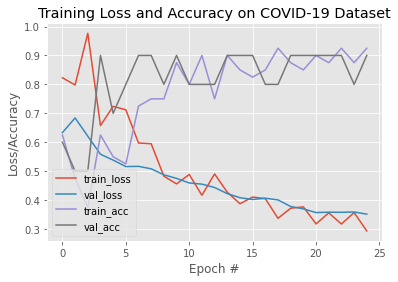

In [11]:
%matplotlib inline

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), HEAD.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), HEAD.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), HEAD.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), HEAD.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/plot")

In [12]:
# Serialize model to disk
print("[INFO] saving COVID-19 detector model...")
model.save("model/COV19.model", save_format="h5")

[INFO] saving COVID-19 detector model...


In [39]:
# TODO: fix this
import random
def visualize_prediction(classifier, n_cases):

  # Loop through images
  for i in range(0,n_cases):

    # Set path for test images
    #path = random.choice([test_LR_dir, test_RL_dir])
    path = 'data/val'

    # Get pictures
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)    # Image data encoded as integers in the 0-255 range
    img_tensor /= 255.                      # Normalize to [0,1] for matplotlib application

    # Extract feature
    features = model.predict(img_tensor.reshape(1, 224, 224, 3))

    # Make prediction

    prediction = classifier.predict(features)


    # Show image with prediction
    plt.title(random_img)
    plt.imshow(img_tensor)
    plt.show()

    # Write prediction
    if prediction < 0.5:
        print('Co')
    else:
        print('No')


# Visualize predictions
visualize_prediction(model, 2)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (1, 2)